##### Спецкурс "Методы и алгоритмы компьютерного зрения"
---

## Часть 2. Трехмерная реконструкция

#### 1. Постановка задачи

**Дано:**

В файле "House/Data3D.pkl" находится словарь {'Points2D' : points2D, 'Points3D' : points3D, 'Accord': corr, 'Camera': P, 'View1': im1, 'View2': im2}, который содержит:

1) Два изображения одного обекта "**im1**"  и  "**im2**".

2) Пиксельные координаты некоторых точек $\mathrm{x}_i$, $\mathrm{x}_i^{\prime}$ на этих изображениях: список **points2D = [массив: точки первого изображения, массив : точки второго изображения]**. Точки первого и второго изображений -- это массивы размера (2,:)

3) Соответствия между точками $\mathrm{x}_i\leftrightarrow \mathrm{x}_i^{\prime}$ в массиве Numpy "**corr**" размера (:, 2)

4) Матрицы камер $\mathrm{L}_1$ и $\mathrm{L}_2$ в списке P = [P1, P2].

5) Координаты точек $\mathrm{P}_i\in\mathbf{R}^3$ таких, что $\mathrm{L}_1\mathrm{P}_i=\mathrm{x}_i$, $\mathrm{L}_2\mathrm{P}_i=\mathrm{x}_i^{\prime}$: массив **points3D** размера (3, 575)

**Требуется:**

1) Написать фунцию на языке Python "**Triangulation( L1, L2, x1, x2 )**"  которая по соответствующим точкам изображений $\mathrm{x}_i \leftrightarrow \mathrm{x}_i^{\prime}$ возвращает координаты точки $\tilde{\mathrm{P}}_i\in\mathbf{R}^3$, для которой $\mathrm{L}_1\tilde{\mathrm{P}}_i=\mathrm{x}_i$, $\mathrm{L}_2\tilde{\mathrm{P}}_i=\mathrm{x}_i^{\prime}$. Вывести на один рисунок заданные точки $\mathrm{P}_i\in\mathbf{R}^3$ и найденные $\tilde{\mathrm{P}}_i\in\mathbf{R}^3$.

2) С помощью RQ-разложения найти калибровочные матрицы $\mathrm{K}_1$ и $\mathrm{K}_2$ камер.

3) Перейти к нормированным координатам $\hat{\mathrm{x}}_i=\mathrm{K}_1^{-1}\mathrm{x}_i$, $\hat{\mathrm{x}}_i^{\prime}=\mathrm{K}_2^{-1}\mathrm{x}_i^{\prime}$. Используя восьмиточечный алгоритм, найти существенную матрицу $\mathrm{I}$.

4) По найденной существенной матрице и первой камере $\mathrm{L}_1=\begin{pmatrix} 1&0&0&0\\ 0&1&0&0\\ 0&0&1&0 \end{pmatrix}$ определить четыре возможных значения для второй камеры.

5) Используя найденные матрицы камер, триангулировать соответсвующие точки (нормированные).

In [1]:
import numpy as np
from PIL import Image
import pickle
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_obj(name):
    ''' Чтение из файла.'''
    obj = pickle.load(open(name, 'rb' ))
    return obj

#### 2. Сингулярное разложение матрицы

$$
\mathrm{A} = \mathrm{UDV}^T 
$$

In [2]:
''' Сингулярное разложение матрицы. Проба '''
A = np.array([[1, 3, 2],[-2, 5, 2], [1, 4, -2], [2, 0, 3]])
U, S, VT = linalg.svd(A, lapack_driver ='gesvd') # SVD матрицы A = U * diag(S) * VT 
D = np.zeros((U.shape[1], VT.shape[0]))
D[:(S.shape[0]), :(S.shape[0])] = np.diag(S)
print(np.linalg.norm(A - U.dot(D.dot(VT)), 'fro'))

2.3863339371437894e-15


#### 3. Нахождение матриц камер по заданной существенной матрицы

**Теорема 1 (Определение матриц камер по заданной существенной матрице).** Для данной существенной матрицы $\mathrm{I=Udiag(1,1,0)V}^{T} $ и первой камеры $\mathrm{L_1=(E|0)}$ существуют четыре возможных варианта для второй камеры:

$$
\mathrm{L}_2=(\mathrm{UWV}^{T} |\mathrm{u}_{3} ) ~\text{или}~ \mathrm{L}_2=(\mathrm{UWV}^{T} |-\mathrm{u}_{3} )\notag\\
\text{или}~ \mathrm{L}_2=(\mathrm{UW}^{T} \mathrm{V}^{T} |\mathrm{u}_{3} )~\text{или}~\mathrm{L}_2=(\mathrm{UW}^{T} \mathrm{V}^{T} |-\mathrm{u}_{3} ),\notag
$$

где $\mathrm{W}=\begin{pmatrix} 0& -1&0 \\ 1&0&0 \\ 0&0&1 \end{pmatrix}$ и $\mathrm{u}_3$ -- последний столбец матрицы $\mathrm{U}$.

In [3]:
def MatrixCamers(norm_matchedPoints1, norm_matchedPoints2):
    '''
        Получение матриц камер по данной существенной матрице,
        которая находится по точечным соответствиям.
        Результат - это список [L, L_prime], содержащий матрицу L_1
        и словарь с четырьмя матрицами L_2
        L_prime = {1: L_2, 2: L_2, 3: L_2, 4: L_2}
    '''
    # Находим существенную матрицу
    E = Fundamental_Matrix_Normaliz(norm_matchedPoints1, norm_matchedPoints2)
    U, D, V = linalg.svd(E, lapack_driver ='gesvd')
    if (np.linalg.det(U.dot(V)) < 0):
        V = -V
    L_prime = {}
    L1 = np.zeros((3, 4))
    
    
    
    # Ваш код для построения L1 ...
    
    
    
    L_prime[(1)] = L1
    L1 = np.zeros((3, 4))
    
    
    
    # Ваш код для построения L1 ...
    
    
    
    L_prime[(2)] = L1
    L1 = np.zeros((3, 4))
    
    
    
    # Ваш код для построения L1 ...
    
    
    
    L_prime[(3)] = L1
    L1 = np.zeros((3, 4))
    
    
    
    # Ваш код для построения L1 ...
    
    
    
    L_prime[(4)] = L1
    return [L, L_prime]

####  4. RQ-алгоритм для матрицы $3\times 3$.

Пусть $\mathrm{L=(M|b)}$ -- матрица камеры, где $\mathrm{M}$ -- матрица $3\times 3$. Для нахождения калибровочной матрицы $\mathrm{K}$ данной камеры представим матрицу $\mathrm{M}$ в виде произведения $\mathrm{M=K\cdot R}$, где $\mathrm{K}=\begin{pmatrix}k_{11}&k_{12}&k_{13}\\0&k_{22}&k_{23}\\0&0&k_{33}\end{pmatrix}$, а $\mathrm{R}$ -- ортогональная матрица.

Введем в рассмотрение ортогональные матрицы 

$$
\mathrm{Q}_x=\begin{pmatrix}1&0&0\\0&c&-s\\0&s&c\end{pmatrix},~\mathrm{Q}_y=\begin{pmatrix}c&0&s\\0&1&0\\-s&0&c\end{pmatrix},~\mathrm{Q}_z=\begin{pmatrix}c&-s&0\\s&c&0\\0&0&1\end{pmatrix}.
$$

Алгоритм RQ-разложения.

1. Находим матрицу $\mathrm{Q}_x$ такую, что у матрицы $\mathrm{B}=\mathrm{M}\mathrm{Q}_x=(b_{ij})_{i,j=1}^3$ элемент $b_{32}=0$.

2. Находим матрицу $\mathrm{Q}_y$ такую, что у матрицы $\mathrm{C}=\mathrm{B}\mathrm{Q}_y=(c_{ij})_{i,j=1}^3$ элемент $c_{31}=0$.

3. Находим матрицу $\mathrm{Q}_z$ такую, что у матрицы $\mathrm{K}=\mathrm{C}\mathrm{Q}_z=(k_{ij})_{i,j=1}^3$ элемент $k_{21}=0$.

4. Искомое разложение $\mathrm{M} = \mathrm{K}\cdot(\mathrm{Q}_x\mathrm{Q}_y\mathrm{Q}_z)^{-1}$.

In [4]:
def RQ_Decomposition( A ):
    ''' 
    Алгоритм RQ- разложения матрицы
    '''
    
    
    
    # Ваш код ...
    
    
    
    
    return [R, Q]

In [5]:
''' Проба. '''
A = np.array([[1, 2, 3], [-2, 2, -3], [4, 5, 6]])
Y = RQ_Decomposition(A)
print(Y[0].dot(Y[1]))

[[ 1.  2.  3.]
 [-2.  2. -3.]
 [ 4.  5.  6.]]


#### 5. Триангуляция

Пусть  $\mathrm{x}_i\leftrightarrow\mathrm{x}_i^{\prime}$. Из равенств $\mathrm{L_1P}_i=\lambda_1\mathrm{x}_i$, $\mathrm{L_2 P}_i=\lambda_2\mathrm{x}_i^{\prime}$ получаем систему линейных уравнений для определения точки $\mathrm{P}_i$

$$
\begin{pmatrix}\mathrm{L}_1&-\mathrm{x}_i&0\\ \mathrm{L}_2&0&-\mathrm{x}_i^{\prime}\end{pmatrix}\cdot\begin{pmatrix}\mathrm{P}_i\\ \lambda_1 \\ \lambda_2\end{pmatrix}=0,~\left\|\begin{pmatrix}\mathrm{P}_i\\ \lambda_1 \\ \lambda_2\end{pmatrix}\right\|=1.
$$

Из-за зашумленности изображения, погрешностей в определении матриц камер и т. д. у этой системы может не быть точного решения. Но с помощью сингулярного разложения мы найдем приближенное положение $\tilde{\mathrm{P}}_i$ точки $\mathrm{P}_i$, минимизирующее среднеквадратическую ошибку. Итак, если $\mathrm{A}=\begin{pmatrix}\mathrm{L}_1&-\mathrm{x}_i&0\\ \mathrm{L}_2&0&-\mathrm{x}_i^{\prime}\end{pmatrix}$ и $\mathrm{A=UDV^T}$ -- SVD матрицы $\mathrm{A}$, то однородные координаты точки $\tilde{\mathrm{P}}_i(\xi_1:\xi_2:\xi_3:\xi_4)$ -- это первые четыре элемента последнего столбца матрицы $\mathrm{V}$. Аффинные координаты $\begin{pmatrix}y_1&y_2&y_3\end{pmatrix}^T$ точки $\tilde{\mathrm{P}}_i$ определяются равенствами $y_s=\frac{\xi_s}{\xi_4}$, $s=1,2,3$.

In [6]:
def Triangulation(L1, L2, X1, X2 ):
    ''' Триангуляция. Результат -- это вектор P = np.array([p_1, p_2, 1]). Третья координата равна 1. '''
    
    
    
    # Ваш код ...
    
    
    
    return P

#### 6. Загружаем точки, камеры, изображения

(-0.5, 1023.5, 767.5, -0.5)

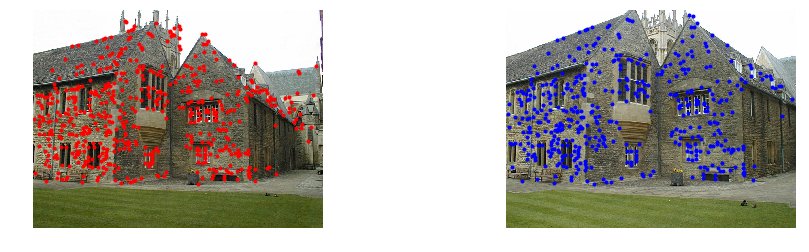

In [7]:
''' 
Загружаем данные.
{'Points2D' : points2D, 'Points3D' : points3D, 'Accord': corr, 'Camera': P, 'View1': im1, 'View2': im2}
'''
Data3D = load_obj('House/Data3D.pkl')
fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(Image.fromarray(Data3D[('View1')]))
ax1.plot(Data3D[('Points2D')][0][0,:], Data3D[('Points2D')][0][1,:], '.r')
ax1.axis('off')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(Image.fromarray(Data3D[('View2')]))
ax2.plot(Data3D[('Points2D')][1][0,:], Data3D[('Points2D')][1][1,:], '.b')
ax2.axis('off')

In [8]:
Accord = Data3D[('Accord')]
N = Accord.shape[0]
matchedPoints1 = np.zeros((3, N))
matchedPoints2 = np.zeros((3, N))
matchedPoints1[:2, :] = Data3D[('Points2D')][0][:, Accord[:,0]]
matchedPoints1[2, :] = 1
matchedPoints2[:2, :] = Data3D[('Points2D')][1][:, Accord[:,1]]
matchedPoints2[2, :] = 1

In [9]:
print(matchedPoints1)

[[645.612 616.38  587.118 ... 628.349 854.175 432.838]
 [385.016 359.62  361.451 ... 307.635 404.923 484.326]
 [  1.      1.      1.    ...   1.      1.      1.   ]]


In [10]:
print(Data3D[('Camera')][0])

[[ 6.89445992e+01 -9.55613469e+02  6.50567300e+02  8.08414734e+03]
 [-9.88710005e+02 -4.54107342e+02 -2.27456676e+02  9.85185196e+03]
 [ 1.04939283e-01 -8.78219302e-01 -4.66603263e-01  1.72245042e+01]]


#### 7. Триангулируем точки, используя функцию Triangulation

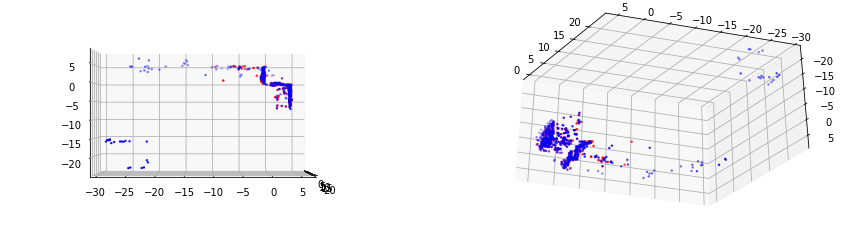

In [11]:
Y = np.zeros((3, N))
for j in range(N):
    Pj = Triangulation(Data3D[('Camera')][0], Data3D[('Camera')][1], matchedPoints1[:, j], matchedPoints2[:, j])
    Y[:, j] = Pj[:3]
fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter3D(Y[0, :], Y[1, :], Y[2, :], c = 'r', linewidth = 0.1, marker='.')
ax1.scatter3D(Data3D[('Points3D')][0,:], Data3D[('Points3D')][1,:], Data3D[('Points3D')][2,:], c = 'b', linewidth = 0.1, marker='.')
ax1.view_init(0, 0)
ax2.scatter3D(Y[0, :], Y[1, :], Y[2, :], c = 'r', linewidth = 0.1, marker='.')
ax2.scatter3D(Data3D[('Points3D')][0,:], Data3D[('Points3D')][1,:], Data3D[('Points3D')][2,:], c = 'b', linewidth = 0.1, marker='.')
ax2.view_init(146, -155)
plt.show()

#### 8. Находим калибровочные матрицы, используя функцию RQ_Decomposition

In [12]:
E = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.]])
M = Data3D[('Camera')][0][:, :3]
K1, R1 = RQ_Decomposition( M )
b1 = np.dot(np.linalg.inv(M), Data3D[('Camera')][0][:, 3])
Eb1 = E
Eb1[:, 3] =  b1[:]
L1_= np.dot(K1, np.dot(R1, Eb1))
Er1 = np.linalg.norm(Data3D[('Camera')][0] - L1_)
print(Er1)
print(K1)

2.040235341980665e-12
[[1.02295166e+03 1.08357767e-13 5.42916365e+02]
 [0.00000000e+00 1.03660475e+03 4.01183341e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [13]:
M = Data3D[('Camera')][1][:, :3]
K2, R2 = RQ_Decomposition( M )
b2 = np.dot(np.linalg.inv(M), Data3D[('Camera')][1][:, 3])
Eb2 = E
Eb2[:, 3] =  b2[:]
L2_= np.dot(K2, np.dot(R2, Eb2))
Er2 = np.linalg.norm(Data3D[('Camera')][1] - L2_)
print(Er2)
print(K2)

1.8376778803935095e-12
[[1.03737096e+03 5.00044450e-13 5.76983080e+02]
 [0.00000000e+00 1.04037325e+03 3.94246403e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


#### 9. Нахождение фундаментальной матрицы

Рассмотрим алгоритм нахождения фундаментальной матрицы. Уравнение $\mathrm{x'}^{T} \mathrm{Fx}=0$ накладывает ограничения на пары соответствующих точек. Пусть даны соответствия

$$
\mathrm{x}\leftrightarrow \mathrm{x'},~\mathrm{x}=\begin{pmatrix}u&v&1\end{pmatrix}^{T} ,~\mathrm{x'}=\begin{pmatrix}u' & v' & 1\end{pmatrix}^{T}.
$$

Тогда можно записать

$$
\begin{pmatrix} u'&v'&1\end{pmatrix} \begin{pmatrix} F_{11}&F_{12}&F_{13} \\ F_{21}&F_{22}&F_{23} \\ F_{31}&F_{32}&F_{33}\end{pmatrix} \begin{pmatrix}{u} \\ {v} \\ {1} \end{pmatrix}=\begin{pmatrix}{0} \\ {0} \\ {0} \end{pmatrix}.
$$

Если обозначить $\mathrm{f}=\begin{pmatrix} F_{11}&F_{12}&F_{13}&F_{21}&F_{22}&F_{23}&F_{31}&F_{32}\end{pmatrix}^{T}$, то последнее уравнение можно записать в виде

$$
\begin{pmatrix} u'u&u'v&u'&v'u&v'v&v'& u&v&1\end{pmatrix} \mathrm{f}=0.
$$

Для множества из $n$ точечных соответствий мы получим однородную систему линейных уравнений

$$
\mathrm{Af}=\begin{pmatrix} u'_{1} u_{1}&u'_{1} v_{1}&u'_{1} &v'_{1} u_{1}&v'_{1} v_{1} &v'_{1}&u_{1}&v_{1}&1 \\ \dots&\dots&\dots&\dots&\dots&\dots&\dots&\dots& \dots\\ u'_{n} u_{n}& u'_{n} v_{n}& u'_{n}&v'_{n} u_{n}&v'_{n} v_{n}&v'_{n}&u_{ n}&v_{n}&1 \end{pmatrix}\mathrm{f}=0.
$$

Если имеется $n\geqslant 8$ соответствий, то матрицу $\mathrm{F}$ можно вычислить, решив полученную систему методом наименьших квадратов. А именно, если SVD матрицы $\mathrm{A}$ имеет вид $\mathrm{A=UDV}^{T} $, то вектор $\mathrm{f},~\left\| \mathrm{f}\right\| =1$, являющийся решением системы, представляет собой последний столбец матрицы $\mathrm{V}$.

В рассмотренном методе не учитывается, что фундаментальная матрица имеет ранг 2. Будем искать матрицу $\mathrm{F'},~\mathrm{rg}\mathrm{F'}=2$ из условия: $\mathrm{F'}=\arg \min\limits_{\mathrm{F'},~rg\mathrm{F'}=2} \left\| \mathrm{F-F'}\right\| _{2} $. Тогда, если найти SVD матрицы $\mathrm{F=U} \mathrm{diag}\left(\sigma _{1} ,\sigma _{2} ,\sigma _{3} \right)\mathrm{V}^T$, то

$$
\mathrm{F'}=\mathrm{U} \mathrm{diag} \left(\sigma _{1} ,\sigma _{2} ,0\right)\mathrm{V}^T.
$$

Данный метод нахождения фундаментальной матрицы называется **8-точечным алгоритмом**. Рассмотрим следующую модификацию алгоритма, которая получила название **нормализованного 8-точечного алгоритма**. В качестве нормализации предлагается осуществить два преобразования системы координат изображений, такие как перенос и масштабирование. Таким образом, если $\mathrm{m}=\frac{1}{N}\sum\limits_{i=1}^N\mathrm{x}_i = \begin{pmatrix}m_1&m_2&1\end{pmatrix}$ и $\sigma = \sqrt{\frac{1}{N-1}\sum\limits_{i=1}^N\left|\mathrm{x}_i-\mathrm{m}\right|^2}$, то нормализация имеет вид $\tilde{\mathrm{x}}_i = s(\mathrm{x}_i-\mathrm{m})$, где $s = \frac{\sqrt{2}}{\sigma}$. Следовательно,

$$
\tilde{\mathrm{x}}_i=\mathrm{T}\mathrm{x}_i, ~~~~ \mathrm{T}=\begin{pmatrix}s & 0 & -sm_1\\ 0 & s & -s m_2\\ 0 & 0 & 1\end{pmatrix}. ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ (1)
$$

**Алгоритм**

1) Нормализация. Осуществляем преобразование (1) точек первого изображения. Находим аналогичное (1) преобразование $\mathrm{T'}: \mathrm{x'}_{i} \mapsto \tilde{\mathrm{x}}'_{i} $ точек второго изображения.

3) Применяем 8-точечный алгоритм для соответствий $\tilde{\mathrm{x}}_{i} \mapsto \tilde{\mathrm{x}}'_{i} $. Получаем матрицу $\tilde{\mathrm{F}}$.  Для нее $\mathrm{\tilde{x'}}_i^T\cdot \mathrm{\tilde{F}}\cdot  \mathrm{\tilde{x}}_i=0$.

4) Искомая матрица $\mathrm{F}=\mathrm{T'}^{T} \tilde{\mathrm{F}}\mathrm{T}$.

In [14]:
def Fundamental_Matrix_Normaliz(X1, X2):
    '''
    Функция, осуществляющая построение фундаментальной матрицы пары камер по нормализованному алгоритму.
    Вход: Локальные особенности изображений $X1 = (u_1, v_1, 1)$, $X2 = (u_2, v_2, 1)$ -- массивы 3xN
    Выход: фундаментальная матрица пары камер.
    '''
    # Нормализация
    N = np.min([X1.shape[1], X2.shape[1]])
    mean_1 = np.mean(X1[:2,:N], axis = 1)
    S1 = np.sqrt(2) / np.std(X1[:2,:N])
    mean_2 = np.mean(X2[:2,:N], axis = 1)
    S2 = np.sqrt(2) / np.std(X2[:2,:N])
    T1 = np.array([[S1, 0, -S1 * mean_1[0]], [0, S1, -S1 * mean_1[1]], [0, 0, 1]])
    T2 = np.array([[S2, 0, -S2 * mean_2[0]], [0, S2, -S2 * mean_2[1]], [0, 0, 1]])
    hatX1 = np.dot(T1, X1[:, :N])
    hatX2 = np.dot(T2, X2[:, :N])
    # Находим фундаментальную матрицу для нормализованных векторов
    
    
    
    
    # Ваш код ....
    
    
    
    
    # Возврат к старым координатам
    F = np.dot(T2.T, np.dot(F, T1))
    return F

#### 10. Трехмерная реконструкция

In [15]:
# Переходим к нормированным координатам
norm_matchedPoints1 = (np.linalg.inv(K1)).dot(matchedPoints1)
norm_matchedPoints1 = norm_matchedPoints1 / norm_matchedPoints1[2, :]
norm_matchedPoints2 = (np.linalg.inv(K2)).dot(matchedPoints2)
norm_matchedPoints2 = norm_matchedPoints2 / norm_matchedPoints2[2, :]

In [16]:
# Нахождение матриц камер по заданной существенной матрице
L1_rec, L2_rec_all = MatrixCamers(norm_matchedPoints1, norm_matchedPoints2)
print(L1_rec)
print(L2_rec_all)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
{1: array([[ 0.15115129,  0.00398999,  0.98850259, -0.8011532 ],
       [ 0.01403435, -0.99989973,  0.00189001,  0.00978332],
       [ 0.98841101,  0.01358732, -0.15119213, -0.59837935]]), 2: array([[ 0.15115129,  0.00398999,  0.98850259,  0.8011532 ],
       [ 0.01403435, -0.99989973,  0.00189001, -0.00978332],
       [ 0.98841101,  0.01358732, -0.15119213,  0.59837935]]), 3: array([[ 0.99033622,  0.02983359,  0.13544047, -0.8011532 ],
       [-0.02797369,  0.99948669, -0.0156151 ,  0.00978332],
       [-0.13583681,  0.01167543,  0.99066243, -0.59837935]]), 4: array([[ 0.99033622,  0.02983359,  0.13544047,  0.8011532 ],
       [-0.02797369,  0.99948669, -0.0156151 , -0.00978332],
       [-0.13583681,  0.01167543,  0.99066243,  0.59837935]])}


**Выбираем нужную камеру** по наибольшему количеству точек, находящихся перед камерой. Если $P_j$ - точка после триангуляции, то находим ее проекции на плоскости изображений $x=L_{1,rec}P_j$, $x'=L_{2,rec}Pj$. Точка находится перед камерами, 
если ее третья координата положительна: $x_3 > 0$ и $x'_3 > 0$.

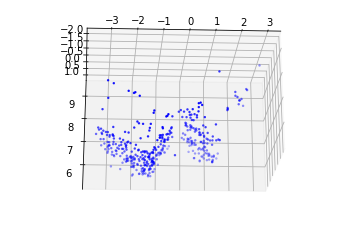

In [17]:
P_all = {}
NumP = np.zeros(4)
for i in range(4):
    L2_rec = L2_rec_all[(i + 1)]
    Y = np.zeros((3, N))
    s = 0;
    for j in range(N):
        Pj = Triangulation(L1_rec, L2_rec, norm_matchedPoints1[:, j], norm_matchedPoints2[:, j])
        x1 = L1_rec.dot(Pj)
        x2 = L2_rec.dot(Pj)
        if ((x1[2] > 0) and (x2[2] > 0)):
            Y[:, s] = Pj[:3]
            s += 1
    NumP[i] = s
    P_all[(i)] = Y
i = np.argmax(NumP)
Y = P_all[(i)]
ax = plt.axes(projection = '3d')
ax.scatter3D(Y[0, :], Y[1, :], Y[2, :], c = 'b', linewidth = 0.1, marker='.')
ax.view_init(-23, -93)

#### Список использованных источников.

1. Используется один из оксфордских многовидовых наборов, предложенных на странице
https://www.robots.ox.ac.uk/~vgg/data/mview/

2. Jan Erik Solem. Programming Computer Vision with Python. O'Reilly, 2012, pp. 264

3. Richard Hartley, Andrew Zisserman. Multiple View Geometry in Computer Vision. CAMBRIDGE UNIVERSITY PRESS, 2000. - p. 607.

4. Форсайт Дэвид, Понс Жан. Компьютерное зрение. Современный подход.: Пер. с англ. -- М.: Издательский дом <<Вильямс>>, 2004. -- 928 с.: ил.